In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
default = pd.read_csv('../data/Default.csv', index_col=0)
default.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


### Figure 4.1 Default data set

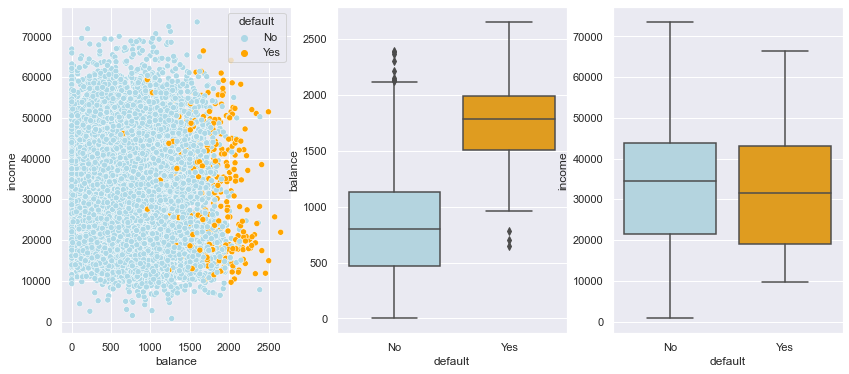

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
col_pal = {'No':'lightblue', 'Yes':'orange'}
sns.scatterplot(x='balance', y='income', hue='default', data=default, ax=ax[0], palette=col_pal);
sns.boxplot(x='default', y='balance', data=default, palette=col_pal, ax=ax[1]);
sns.boxplot(x='default', y='income', data=default, palette=col_pal, ax=ax[2]);

### Figure 4.2 Linear and Logistic regression on Default data set

In [4]:
default['default_int'] = default.default.map({'No':0, 'Yes':1})
default['student_int'] = default.student.map({'No':0, 'Yes':1})

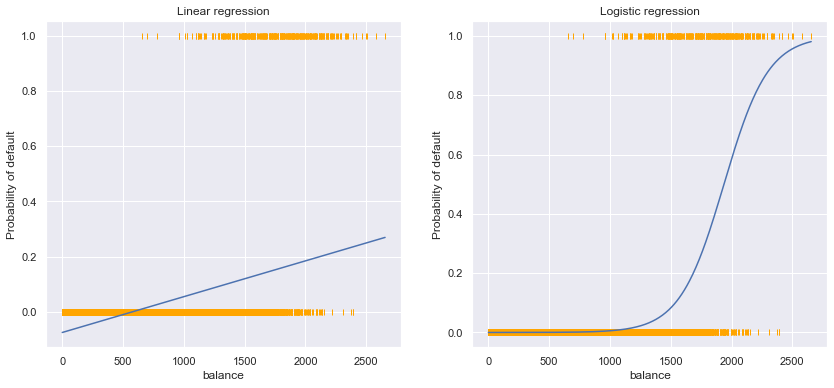

In [5]:
from sklearn.linear_model import LinearRegression, LogisticRegression

lin_reg = LinearRegression()
XTrain = default.balance.values.reshape(-1, 1)
yTrain = default.default_int.values
XTest = np.linspace(default.balance.min(), default.balance.max(), 500).reshape(-1, 1)
lin_reg.fit(XTrain, yTrain)
lin_pred = lin_reg.predict(XTest)

log_reg = LogisticRegression(solver='newton-cg')
log_reg.fit(XTrain, yTrain)
probs = log_reg.predict_proba(XTest)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot('balance', 'default_int', '|', color='orange', data=default)
ax[0].plot(XTest, lin_pred)
ax[0].set_xlabel('balance')
ax[0].set_ylabel('Probability of default')
ax[0].set_title('Linear regression')

ax[1].plot('balance', 'default_int', '|', color='orange', data=default)
ax[1].plot(XTest, probs[:, 1])
ax[1].set_xlabel('balance')
ax[1].set_ylabel('Probability of default')
ax[1].set_title('Logistic regression')

plt.show();

### Table 4.1

In [6]:
import statsmodels.formula.api as smf
sm_logit = smf.logit('default_int ~ balance', default).fit()
sm_logit.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006


### Table 4.2

In [7]:
smf.logit('default_int ~ student_int', default)\
    .fit()\
    .summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
student_int,0.4049,0.115,3.520,0.000,0.179,0.630


### Table 4.3

In [8]:
sm_logit = smf.logit('default_int ~ balance + income + student_int', default).fit()
sm_logit.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-10.8690,0.492,-22.079,0.000,-11.834,-9.904
balance,0.0057,0.000,24.737,0.000,0.005,0.006
income,3.033e-06,8.2e-06,0.370,0.712,-1.3e-05,1.91e-05
student_int,-0.6468,0.236,-2.738,0.006,-1.110,-0.184


### Figure 4.3 Confounding

In [9]:
default.groupby(by=['student']).agg(np.mean).default_int['No']

0.02919501133786848

C:\Users\jvenepal\Anaconda3\envs\cs109a\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\jvenepal\Anaconda3\envs\cs109a\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\jvenepal\Anaconda3\envs\cs109a\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\jvenepal\Anaconda3\envs\cs109a\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\jvenepal\Anaconda3\envs\cs109a\lib\site-packages\sklearn\utils\optimize.py:212: Converg

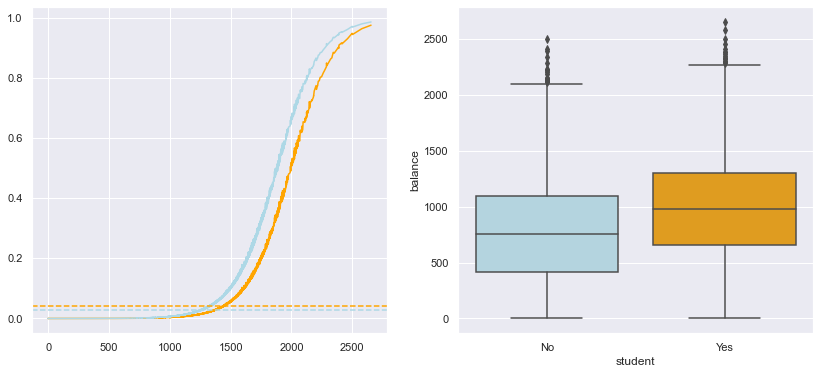

In [10]:
from sklearn.linear_model import LogisticRegression

X = default[['balance', 'income', 'student_int']]
y = default.default_int
clf = LogisticRegression(solver='newton-cg')
clf.fit(X, y)
X_test = X.drop(columns=['student_int']).sort_values(by=['balance'])
X_students = np.c_[X_test, np.ones_like(X['student_int'])]
X_non_students = np.c_[X_test, np.zeros_like(X['student_int'])]
probs1 = clf.predict_proba(X_students)
probs2 = clf.predict_proba(X_non_students)

fig, ax = plt.subplots(1,2, figsize=(14, 6))
# TODO: left plot: default rate vs. balance
ax[0].plot(X_test.balance, probs1[:, 1], color=col_pal['Yes'], label='Student')
ax[0].plot(X_test.balance, probs2[:, 1], color=col_pal['No'], label='Non-Student')
mean_default_rates = default.groupby(by=['student']).agg(np.mean).default_int
ax[0].axhline(mean_default_rates['No'], color=col_pal['No'], linestyle='--')
ax[0].axhline(mean_default_rates['Yes'], color=col_pal['Yes'], linestyle='--')

sns.boxplot(x='student', y='balance', data=default, ax=ax[1], palette=col_pal);

### Table 4.4 Confusion matrix for LDA on Default data set

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

X = default[['balance', 'income', 'student_int']]
y = default['default_int']
clf = LinearDiscriminantAnalysis()
clf.fit(X, y)
predictions = clf.predict(X)
confusion_matrix(y, predictions)

array([[9645,   22],
       [ 254,   79]], dtype=int64)

### Table 4.5 Changing the decision boundary

In [12]:
decision_prob = 0.2
probs = clf.predict_proba(X)
confusion_matrix(y, probs[:, 1] > decision_prob)

array([[9435,  232],
       [ 140,  193]], dtype=int64)

### Figure 4.7 Error rate vs. decision boundary thresholda

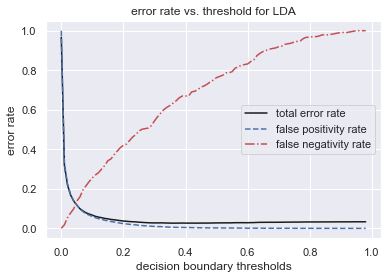

In [13]:
thresholds = np.arange(0, .99, .01)
ter, fpr, fnr = [], [], [] # total error rate, false positive rate, false negative rate
tpr = []
for threshold in thresholds:
    tn, fp, fn, tp = confusion_matrix(y, probs[:, 1] > threshold).ravel()
    ter.append((fp + fn) / (tn + fp + fn + tp))
    fpr.append(fp / (fp + tn))
    tpr.append(tp / (fn + tp))
    fnr.append(fn / (fn + tp))
plt.plot(thresholds, ter, 'k-', label='total error rate')
plt.plot(thresholds, fpr, 'b--', label='false positivity rate')
plt.plot(thresholds, fnr, 'r-.', label='false negativity rate')
plt.xlabel('decision boundary thresholds')
plt.ylabel('error rate')
plt.title('error rate vs. threshold for LDA')
plt.legend();

### Figure 4.8 ROC

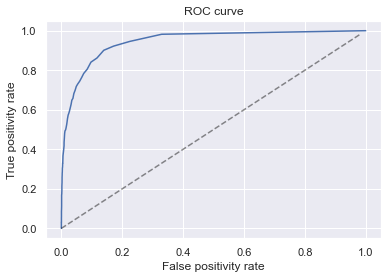

In [14]:
plt.plot(fpr, tpr)
plt.xlabel('False positivity rate')
plt.ylabel('True positivity rate')
plt.title('ROC curve')
plt.plot(thresholds, thresholds, 'k--', alpha=0.5);

### Figure 4.9 QDA

In [15]:
# TODO
# example: https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py